In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, ConfusionMatrixDisplay, precision_score, recall_score

import tensorflow_addons as tfa
from tensorflow import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dense, BatchNormalization, Dropout
from keras.metrics import BinaryAccuracy
import keras.backend as K

from xgboost import XGBClassifier

In [ ]:
data = pd.read_csv("creditcard.csv")
data.head()

In [ ]:
data.info()

In [ ]:
data['Class'].value_counts()

In [ ]:
data.groupby('Class').describe()['Amount'].T

In [ ]:
scalar = StandardScaler()
X = data.drop('Class', axis=1)
y = data.Class

X_train_v, X_test, y_train_v, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train, X_validate, y_train, y_validate = train_test_split(X_train_v, y_train_v, test_size=0.2, random_state=42)

X_train = scalar.fit_transform(X_train)
X_validate = scalar.transform(X_validate)
X_test = scalar.transform(X_test)

In [ ]:
def print_score(label, prediction, train=True):
    if train:
        clf_report = pd.DataFrame(classification_report(label, prediction, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(label, prediction) * 100:.2f}%")
        print("_______________________________________________")
        print(f"Classification Report:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_train, prediction)}\n")
        
    else:
        clf_report = pd.DataFrame(classification_report(label, prediction, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(label, prediction) * 100:.2f}%")
        print("_______________________________________________")
        print(f"Classification Report:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(label, prediction)}\n")


def get_f1(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [ ]:
model = keras.Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[-1],)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(1, activation='sigmoid'),
])

model.summary()

In [ ]:
w_p = y_train.value_counts()[0] / len(y_train)
w_n = y_train.value_counts()[1] / len(y_train)
print(f"Fraudulant transaction weight: {w_n}")
print(f"Non-Fraudulant transaction weight: {w_p}")

# model.compile(optimizer=keras.optimizers.Adam(1e-4), loss='binary_crossentropy', metrics=get_f1)
# es = EarlyStopping(monitor='val_loss', mode='min', patience=50)
# mc = ModelCheckpoint('best_model.h5', save_best_only=True)
# class_weight = {0: w_p, 1: w_n}

# r = model.fit(
#     X_train, y_train, 
#     validation_data=(X_validate, y_validate),
#     batch_size=2048, 
#     epochs=300, 
#     verbose=1,
#     # class_weight=class_weight,
#     callbacks=[mc, es],
# )

In [ ]:
def custom_f1(y_true, y_pred):    
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        
        recall = TP / (Positives+K.epsilon())    
        return recall 
    
    
    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    
        precision = TP / (Pred_Positives+K.epsilon())
        return precision 
    
    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)
    
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


f1_cv, precision_cv, recall_cv = [], [], []

current_folds = 5
current_epochs = 20
current_batch_size = 112

kfold = StratifiedKFold(current_folds, random_state=42, shuffle=True)

for k_fold, (tr_inds, val_inds) in enumerate(kfold.split(X=X_train_v.values, y=y_train_v.values)):
    print('---- Starting fold %d ----'%(k_fold+1))
    
    x_tr, y_tr = X_train_v.values[tr_inds], y_train_v.values[tr_inds]
    x_val, y_val = X_train_v.values[val_inds], y_train_v.values[val_inds]
    
    # model = runModel(x_tr, y_tr, x_val, y_val, epos=current_epochs)
    
    model.compile(loss='binary_crossentropy', optimizer= "adam",
                  metrics=[BinaryAccuracy(), tfa.metrics.F1Score(num_classes=2, average='micro', threshold=0.5)])
    model.fit(x_tr, 
              y_tr,                  
              epochs=current_epochs, 
              batch_size=current_batch_size,   
              verbose=1)
    
    y_val_pred = model.predict(x_val)
    y_val_pred_cat = (np.asarray(y_val_pred)).round()
    
    f1, precision, recall = f1_score(y_val, y_val_pred_cat), precision_score(y_val, y_val_pred_cat), recall_score(y_val, y_val_pred_cat)
    metric_text = f'Fold {k_fold+1} f1 score = '        
   
    f1_cv.append(round(f1, 6))
    precision_cv.append(round(precision, 6))
    recall_cv.append(round(recall, 6))

metric_text_final = f'Mean f1 score through CV = {np.mean(f1_cv)}'

In [ ]:
plt.figure(figsize=(20, 3))

plt.subplot(1, 2, 1)
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_Loss')
plt.title('Loss Function evolution during training')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(r.history['get_f1'], label='get_f1')
plt.plot(r.history['val_get_f1'], label='val_get_f1')
plt.title('Accuracy evolution during training')
plt.legend()

In [ ]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print_score(y_train, y_train_pred.round(), train=True)
print_score(y_test, y_test_pred.round(), train=False)

scores_dict = {
    'ANNs': {
        'Train': f1_score(y_train, y_train_pred.round()),
        'Test': f1_score(y_test, y_test_pred.round()),
    },
}

In [ ]:
f, axes = plt.subplots(1, 2, figsize=(15, 5), sharey='row')

disp = ConfusionMatrixDisplay(confusion_matrix(y_train, y_train_pred.round()), display_labels=['non-fraud', 'fraud'])
disp.plot(ax=axes[0], xticks_rotation=45)
disp.ax_.set_title('train')

disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_test_pred.round()), display_labels=['non-fraud', 'fraud'])
disp.plot(ax=axes[1], xticks_rotation=45)
disp.ax_.set_title('test')

plt.subplots_adjust(wspace=0.40, hspace=0.1)
plt.show()

In [ ]:
xgb_clf = XGBClassifier()
xgb_clf.fit(X_train, y_train)

y_train_pred = xgb_clf.predict(X_train)
y_test_pred = xgb_clf.predict(X_test)

print_score(y_train, y_train_pred, train=True)
print_score(y_test, y_test_pred, train=False)

scores_dict['XGBoost'] = {
    'Train': f1_score(y_train,y_train_pred),
    'Test': f1_score(y_test, y_test_pred),
}

In [ ]:
f, axes = plt.subplots(1, 2, figsize=(15, 5), sharey='row')

disp = ConfusionMatrixDisplay(confusion_matrix(y_train, y_train_pred.round()), display_labels=['non-fraud', 'fraud'])
disp.plot(ax=axes[0], xticks_rotation=45)
disp.ax_.set_title('train')

disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_test_pred.round()), display_labels=['non-fraud', 'fraud'])
disp.plot(ax=axes[1], xticks_rotation=45)
disp.ax_.set_title('test')

plt.subplots_adjust(wspace=0.40, hspace=0.1)
plt.show()

In [ ]:
scores_df = pd.DataFrame(scores_dict)
scores_df.plot(kind='barh', figsize=(15, 8))

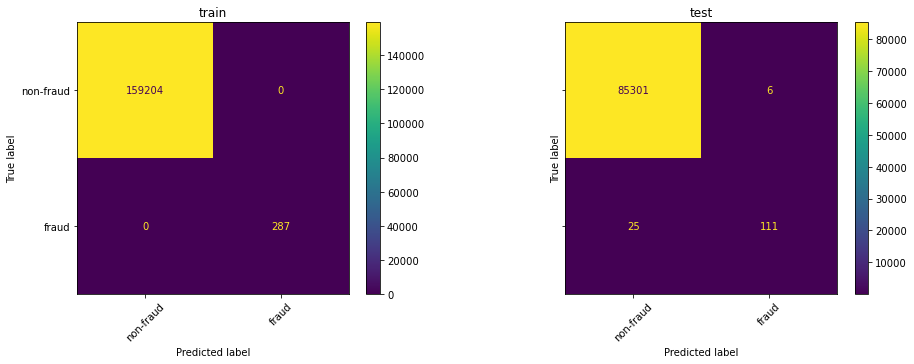

In [17]:
f, axes = plt.subplots(1, 2, figsize=(15, 5), sharey='row')

disp = ConfusionMatrixDisplay(confusion_matrix(y_train, y_train_pred.round()), display_labels=['non-fraud', 'fraud'])
disp.plot(ax=axes[0], xticks_rotation=45)
disp.ax_.set_title('train')

disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_test_pred.round()), display_labels=['non-fraud', 'fraud'])
disp.plot(ax=axes[1], xticks_rotation=45)
disp.ax_.set_title('test')

plt.subplots_adjust(wspace=0.40, hspace=0.1)
plt.show()

<AxesSubplot:>

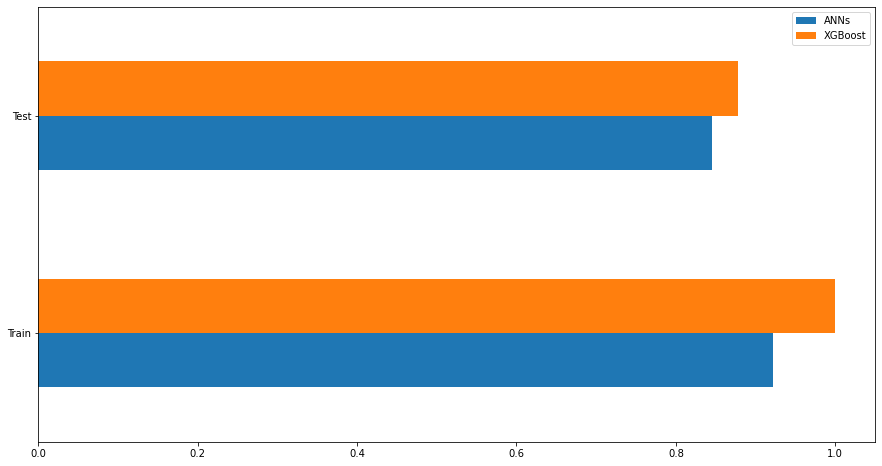

In [14]:
scores_df = pd.DataFrame(scores_dict)
scores_df.plot(kind='barh', figsize=(15, 8))